In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from random import seed

%matplotlib inline

In [2]:
kc1 = pd.read_csv('KC1.csv')
cm1 = pd.read_csv('CM1.csv')
K = [1,3]

kc1 = (kc1 - kc1.min())/(kc1.max() - kc1.min())
cm1 = (cm1 - cm1.min())/(cm1.max() - cm1.min())

kc1['defects'] = kc1.defects.astype('category').cat.codes
cm1['defects'] = cm1.defects.astype('category').cat.codes

kc1.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0.000348,0.009091,0.016,0.009091,0.001175,0.000164,0.650,0.024186,0.006734,0.000004,...,0.007634,0.045455,0.034483,0.166667,0.032432,0.010000,0.001770,0.002804,0.004545,0
1,0.000000,0.000000,0.000,0.000000,0.000904,0.000126,0.500,0.018605,0.005180,0.000003,...,0.003817,0.022727,0.017241,0.083333,0.027027,0.008333,0.001475,0.002336,0.000000,1
2,0.285714,0.227273,0.000,0.227273,0.154611,0.117175,0.020,0.428651,0.208588,0.065820,...,0.248092,0.227273,0.103448,0.000000,0.486486,0.208333,0.157817,0.149533,0.227273,1
3,0.156794,0.159091,0.200,0.159091,0.127486,0.097209,0.035,0.276465,0.268362,0.035211,...,0.141221,0.045455,0.086207,0.000000,0.432432,0.233333,0.131268,0.121495,0.159091,1
4,0.083624,0.045455,0.000,0.045455,0.052441,0.032170,0.055,0.173953,0.141148,0.007334,...,0.080153,0.000000,0.034483,0.000000,0.297297,0.083333,0.060472,0.039720,0.045455,1


In [3]:
def mult(alfa, v):
    return tuple([alfa * x for x in v])


def add(x,y):
    z = list(zip(x,y))
    return tuple([a+b for a,b in z])
    
def sub(x,y):
    z = list(zip(x,y))
    return tuple([a-b for a,b in z])
    

In [4]:
import operator

def euclidean_distance(x,y):
    z = list(zip(x,y))
    ret = 0
    for a,b in z:
        ret += (a-b)**2
    return ret
    

def knn(x,P,k):
    distance = [(euclidean_distance(x,y), i) for i,y in enumerate(P)]
    distance = sorted(distance, key=operator.itemgetter(0))
    
    return distance[0:k]

In [5]:
def lvq1(X, y, P, Py):
    alfa = 0.1
    for t in range(300):
        for k,x in enumerate(X):
            nn = knn(x, P.copy(), 1)
            i = nn[0][1]
            ei = P[i]
            if Py[i] == y[k]:
                P[i] = add(ei,mult(alfa, sub(x, ei)))
            else:
                P[i] = sub(ei,mult(alfa, sub(x, ei)))
        
        alfa = alfa/(1 + alfa)
    
    return P

In [6]:
def lvq2(X, y, P, Py):
    alfa = 0.1
    w = 0.3
    s = (1 - w) / (1 + w)
    P = lvq1(X, y, P, Py)
    for t in range(100):
        for k, x in enumerate(X):
            nn = knn(x, P.copy(), 2)
            
            di,i = nn[0][0], nn[0][1]
            dj,j = nn[1][0], nn[1][1]
            
            window = min(di,dj)/max(di,dj) 
            
            if(window > s):
                if(Py[i] != Py[j]):
                    if(Py[i] == y[k]):
                        P[i] = add(P[i],mult(alfa, sub(x, P[i])))
                        P[j] = sub(P[j],mult(alfa, sub(x, P[j])))
                    else:
                        P[i] = sub(P[i],mult(alfa, sub(x, P[i])))
                        P[j] = add(P[j],mult(alfa, sub(x, P[j])))
        
        alfa = alfa/(1 + alfa)
    return P

In [7]:
def lvq3(X,y,P,Py):
    alfa = 0.1
    w = 0.3
    s = (1-w) / (1+w)
    P = lvq1(X,y,P.copy(),Py)
    epsilon  = 0.4
    for i in range(100):
        for k,x in enumerate(X):
            nn = knn(x,P.copy(),2)
            
            di,i = nn[0][0], nn[0][1]
            dj,j = nn[1][0], nn[1][1]
            
            window = min(di,dj)/max(di,dj)
            
            if(window > s):
                if(Py[i] != Py[j]):
                    if(Py[i] == y[k]):
                        P[i] = add(P[i],mult(alfa, sub(x, P[i])))
                        P[j] = sub(P[j],mult(alfa, sub(x, P[j])))
                    else:
                        P[i] = sub(P[i],mult(alfa, sub(x, P[i])))
                        P[j] = add(P[j],mult(alfa, sub(x, P[j])))
                elif(Py[i] == Py[j] and Py[i] == y[k]):
                    P[i] = add(P[i], mult( epsilon, mult(alfa, sub(x, P[i]))))
                    P[j] = add(P[j], mult( epsilon, mult(alfa, sub(x, P[j]))))
                
        alfa = alfa/(1+alfa)
    return P

In [8]:
def get_accuracy(lista):
    x, y = zip(*lista)
    
    return (np.mean(list(x)), np.mean(list(y)))

In [9]:
from sklearn.neighbors import KNeighborsClassifier


def lvq_k_fold(X,y,num, lvq):

    skf = StratifiedKFold(n_splits=5)
    accuracies = []
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        P = X_train.sample(n=num)
        
        Py = list(y[P.index])
        P = list(P.itertuples(index=False))  

        prototypes = lvq(list(X_train.itertuples(index=False)), list(y_train), P, Py)
        
        P = pd.DataFrame(data=prototypes)
        P.reset_index(drop=True, inplace=True)
        
        
        Py = pd.Series(Py)
        Py.reset_index(drop=True, inplace=True)
        
        accuracy = []
        for k in K:
            tP = P.values.copy()
            tX_test = X_test.values.copy()
            tPy = Py.values.copy()
            
            neigh = KNeighborsClassifier(n_neighbors=k)
            
            neigh.fit(tP, tPy)

            predicted = neigh.predict(tX_test)
            
            matrix = pd.crosstab(predicted, y_test).values
            accuracy.append((np.sum(matrix.diagonal()))/X_test.shape[0])
            
        accuracies.append(tuple(accuracy))
            
        
    return get_accuracy(accuracies)

In [10]:
def start_lvq_k_fold(train, lvq):
      
    accuracy = []
    target = list(train)[-1]
    X = train.drop(target, axis=1)
    y = train[target]
    for i in range(3,10):
        accuracy.append(lvq_k_fold(X, y, i, lvq))

    return accuracy

# Variar o número de protótipos

In [19]:
def plot_(accuracy, ax,title):
    x,y = zip(*accuracy)
    p = list(range(3,10))
    ax.plot( p , y,'r-',label='K = 1')
    ax.plot( p , x,'b-',label='K = 3')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Prototypes')
    ax.set_ylabel('Accuracy')

# Analisando o Desempenho do LVQ1

In [12]:
accuracy = start_lvq_k_fold(kc1,lvq1)
accuracy2 = start_lvq_k_fold(cm1,lvq1)

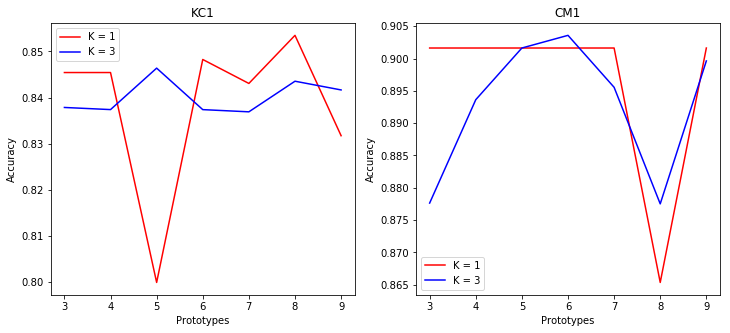

In [20]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plot_(accuracy,ax, 'KC1')
plot_(accuracy2,ax2, 'CM1')
plt.show()

# Analisando o LVQ2.1

In [14]:
accuracy_lvq2 = start_lvq_k_fold(kc1,lvq2)
accuracy2_lvq2 = start_lvq_k_fold(cm1,lvq2)

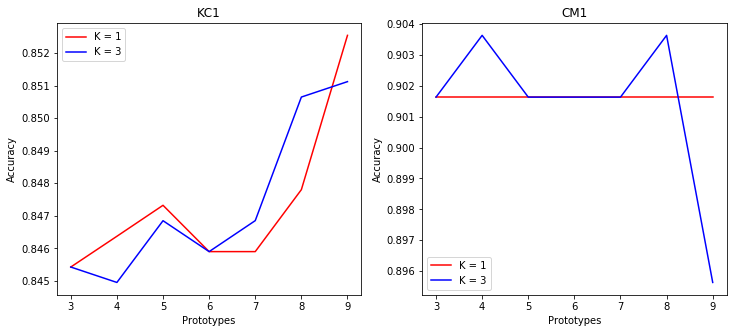

In [21]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plot_(accuracy_lvq2,ax, 'KC1')
plot_(accuracy2_lvq2,ax2, 'CM1')
plt.show()

# Analisando o LVQ3

In [16]:
accuracy_lvq3 = start_lvq_k_fold(kc1,lvq3)
accuracy2_lvq3 = start_lvq_k_fold(cm1,lvq3)

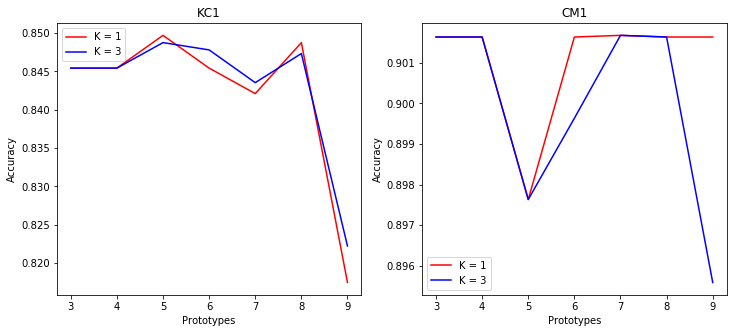

In [22]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plot_(accuracy_lvq3,ax, 'KC1')
plot_(accuracy2_lvq3,ax2, 'CM1')
plt.show()